In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2, random, os

In [2]:
class saved_dataset():
    def __init__(self):
        self.img_names = list()
        self.steer = list()
        self.secim = list()
        self.read_data("logger.csv")

    def read_data(self, folder):
        arr = np.genfromtxt(folder, delimiter=",", dtype=None, encoding='UTF-8')
        for i in range(0, len(arr)):
            name = str(arr[i][0])
            self.img_names.append(name)
            self.steer.append(round(arr[i][1], 2))
            self.secim.append(int(arr[i][2]))

    def __getitem__(self,index):
        return self.img_names[index], self.steer[index], self.secim[index]

    def __len__(self):
        return len(self.img_names)

    def pop(self, index):
        self.img_names.pop(index)
        self.steer.pop(index)
        self.secim.pop(index)

    def __setitem__(self,index,value):
        self.img_names[index], self.steer[index], self.secim[index] = value

    def save(self, filename):
        folder = "logger.csv"
        with open(folder, 'w') as f:
            writer = csv.writer(f)
            for i in range(len(self.img_names)):
                writer.writerow([self.img_names[i], self.steer[i], self.secim[i]])

In [3]:
dataset = saved_dataset()
dataset[0][1:]

(0.0, 0)

[ INFO:0] global /home/aye/opencv_build/opencv/modules/core/src/parallel/registry_parallel.impl.hpp (96) ParallelBackendRegistry core(parallel): Enabled backends(3, sorted by priority): ONETBB(1000); TBB(990); OPENMP(980)


/home/aye/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/aye/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


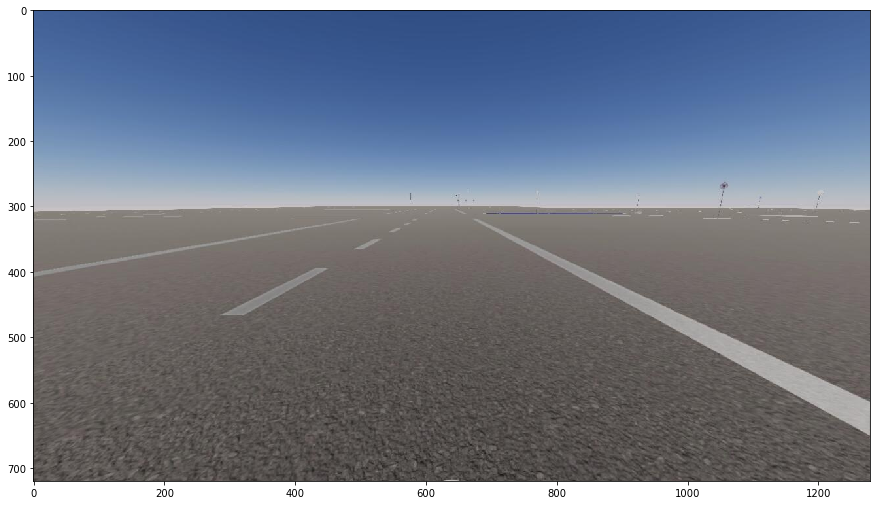

In [4]:
img = dataset[0][0]
img = cv2.imread(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,10))
plt.imshow(img)

In [5]:
def threshold_rel(img, lo, hi):
    vmin = np.min(img)
    vmax = np.max(img)
    
    vlo = vmin + (vmax - vmin) * lo
    vhi = vmin + (vmax - vmin) * hi
    return np.uint8((img >= vlo) & (img <= vhi)) * 255

def threshold_abs(img, lo, hi):
    return np.uint8((img >= lo) & (img <= hi)) * 255

class Thresholding:
    """ This class is for extracting relevant pixels in an image.
    """
    def __init__(self):
        """ Init Thresholding."""
        pass

    def forward(self, img):
        """ Take an image and extract all relavant pixels.

        Parameters:
            img (np.array): Input image

        Returns:
            binary (np.array): A binary image represent all positions of relavant pixels.
        """
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        h_channel = hls[:,:,0]
        l_channel = hls[:,:,1]
        s_channel = hls[:,:,2]
        v_channel = hsv[:,:,2]

        right_lane = threshold_rel(l_channel, 0.8, 1.0)
        right_lane[:,:750] = 0

        left_lane = threshold_abs(h_channel, 20, 30)
        left_lane &= threshold_rel(v_channel, 0.7, 1.0)
        left_lane[:,550:] = 0

        img2 = left_lane | right_lane

        return img2

In [32]:
class PerspectiveTransformation:
    """ This a class for transforming image between front view and top view

    Attributes:
        src (np.array): Coordinates of 4 source points
        dst (np.array): Coordinates of 4 destination points
        M (np.array): Matrix to transform image from front view to top view
        M_inv (np.array): Matrix to transform image from top view to front view
    """
    def __init__(self):
        """Init PerspectiveTransformation."""
        self.src = np.float32([(555, 341), (754, 338), (176, 568), (1280, 546)])
        self.dst = np.float32([(0, 0), (1280, 0), (0, 720), (1280, 720)])
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.M_inv = cv2.getPerspectiveTransform(self.dst, self.src)

    def forward(self, img, img_size=(1280, 720), flags=cv2.INTER_LINEAR):
        """ Take a front view image and transform to top view

        Parameters:
            img (np.array): A front view image
            img_size (tuple): Size of the image (width, height)
            flags : flag to use in cv2.warpPerspective()

        Returns:
            Image (np.array): Top view image
        """
        return cv2.warpPerspective(img, self.M, img_size, flags=flags)

    def backward(self, img, img_size=(1280, 720), flags=cv2.INTER_LINEAR):
        """ Take a top view image and transform it to front view

        Parameters:
            img (np.array): A top view image
            img_size (tuple): Size of the image (width, height)
            flags (int): flag to use in cv2.warpPerspective()

        Returns:
            Image (np.array): Front view image
        """
        return cv2.warpPerspective(img, self.M_inv, img_size, flags=flags)

In [33]:
def hist(img):
    bottom_half = img[img.shape[0]//2:,:]
    return np.sum(bottom_half, axis=0)

class LaneLines:
    """ Class containing information about detected lane lines.

    Attributes:
        left_fit (np.array): Coefficients of a polynomial that fit left lane line
        right_fit (np.array): Coefficients of a polynomial that fit right lane line
        parameters (dict): Dictionary containing all parameters needed for the pipeline
        debug (boolean): Flag for debug/normal mode
    """
    def __init__(self):
        """Init Lanelines.

        Parameters:
            left_fit (np.array): Coefficients of polynomial that fit left lane
            right_fit (np.array): Coefficients of polynomial that fit right lane
            binary (np.array): binary image
        """
        self.left_fit = None
        self.right_fit = None
        self.binary = None
        self.nonzero = None
        self.nonzerox = None
        self.nonzeroy = None
        self.clear_visibility = True
        self.dir = []

        # HYPERPARAMETERS
        # Number of sliding windows
        self.nwindows = 9
        # Width of the the windows +/- margin
        self.margin = 100
        # Mininum number of pixels found to recenter window
        self.minpix = 50

    def forward(self, img):
        """Take a image and detect lane lines.

        Parameters:
            img (np.array): An binary image containing relevant pixels

        Returns:
            Image (np.array): An RGB image containing lane lines pixels and other details
        """
        self.extract_features(img)
        return self.fit_poly(img)

    def pixels_in_window(self, center, margin, height):
        """ Return all pixel that in a specific window

        Parameters:
            center (tuple): coordinate of the center of the window
            margin (int): half width of the window
            height (int): height of the window

        Returns:
            pixelx (np.array): x coordinates of pixels that lie inside the window
            pixely (np.array): y coordinates of pixels that lie inside the window
        """
        topleft = (center[0]-margin, center[1]-height//2)
        bottomright = (center[0]+margin, center[1]+height//2)

        condx = (topleft[0] <= self.nonzerox) & (self.nonzerox <= bottomright[0])
        condy = (topleft[1] <= self.nonzeroy) & (self.nonzeroy <= bottomright[1])
        return self.nonzerox[condx&condy], self.nonzeroy[condx&condy]

    def extract_features(self, img):
        """ Extract features from a binary image

        Parameters:
            img (np.array): A binary image
        """
        self.img = img
        # Height of of windows - based on nwindows and image shape
        self.window_height = np.int(img.shape[0]//self.nwindows)

        # Identify the x and y positions of all nonzero pixel in the image
        self.nonzero = img.nonzero()
        self.nonzerox = np.array(self.nonzero[1])
        self.nonzeroy = np.array(self.nonzero[0])

    def find_lane_pixels(self, img):
        """Find lane pixels from a binary warped image.

        Parameters:
            img (np.array): A binary warped image

        Returns:
            leftx (np.array): x coordinates of left lane pixels
            lefty (np.array): y coordinates of left lane pixels
            rightx (np.array): x coordinates of right lane pixels
            righty (np.array): y coordinates of right lane pixels
            out_img (np.array): A RGB image that use to display result later on.
        """
        assert(len(img.shape) == 2)

        # Create an output image to draw on and visualize the result
        out_img = np.dstack((img, img, img))

        histogram = hist(img)
        midpoint = histogram.shape[0]//2
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Current position to be update later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base
        y_current = img.shape[0] + self.window_height//2

        # Create empty lists to reveice left and right lane pixel
        leftx, lefty, rightx, righty = [], [], [], []

        # Step through the windows one by one
        for _ in range(self.nwindows):
            y_current -= self.window_height
            center_left = (leftx_current, y_current)
            center_right = (rightx_current, y_current)

            good_left_x, good_left_y = self.pixels_in_window(center_left, self.margin, self.window_height)
            good_right_x, good_right_y = self.pixels_in_window(center_right, self.margin, self.window_height)

            # Append these indices to the lists
            leftx.extend(good_left_x)
            lefty.extend(good_left_y)
            rightx.extend(good_right_x)
            righty.extend(good_right_y)

            if len(good_left_x) > self.minpix:
                leftx_current = np.int32(np.mean(good_left_x))
            if len(good_right_x) > self.minpix:
                rightx_current = np.int32(np.mean(good_right_x))

        return leftx, lefty, rightx, righty, out_img

    def fit_poly(self, img):
        """Find the lane line from an image and draw it.

        Parameters:
            img (np.array): a binary warped image

        Returns:
            out_img (np.array): a RGB image that have lane line drawn on that.
        """

        leftx, lefty, rightx, righty, out_img = self.find_lane_pixels(img)

        if len(lefty) > 1:
            self.left_fit = np.polyfit(lefty, leftx, 2)
        if len(righty) > 1:
            self.right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        maxy = img.shape[0] - 1
        miny = img.shape[0] // 3
        if len(lefty):
            maxy = max(maxy, np.max(lefty))
            miny = min(miny, np.min(lefty))

        if len(righty):
            maxy = max(maxy, np.max(righty))
            miny = min(miny, np.min(righty))

        ploty = np.linspace(miny, maxy, img.shape[0])
        if self.left_fit is not None or self.right_fit is not None:
            left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
            right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]

        # Visualization
            for i, y in enumerate(ploty):
                l = int(left_fitx[i])
                r = int(right_fitx[i])
                y = int(y)
                cv2.line(out_img, (l, y), (r, y), (0, 255, 0))
                
            lR, rR, pos = self.measure_curvature()

        return out_img

    def plot(self, out_img):
        np.set_printoptions(precision=6, suppress=True)
        lR, rR, pos = self.measure_curvature()

        value = None
        if abs(self.left_fit[0]) > abs(self.right_fit[0]):
            value = self.left_fit[0]
        else:
            value = self.right_fit[0]

        if abs(value) <= 0.00015:
            self.dir.append('F')
        elif value < 0:
            self.dir.append('L')
        else:
            self.dir.append('R')
        
        if len(self.dir) > 10:
            self.dir.pop(0)

        W = 400
        H = 500
        widget = np.copy(out_img[:H, :W])
        widget //= 2
        widget[0,:] = [0, 0, 255]
        widget[-1,:] = [0, 0, 255]
        widget[:,0] = [0, 0, 255]
        widget[:,-1] = [0, 0, 255]
        out_img[:H, :W] = widget

        direction = max(set(self.dir), key = self.dir.count)
        msg = "Keep Straight Ahead"
        curvature_msg = "Curvature = {:.0f} m".format(min(lR, rR))
        if direction == 'L':
            msg = "Left Curve Ahead"

        if direction == 'R':
            msg = "Right Curve Ahead"

        cv2.putText(out_img, msg, org=(10, 240), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)
        if direction in 'LR':
            cv2.putText(out_img, curvature_msg, org=(10, 280), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)

        cv2.putText(
            out_img,
            "Good Lane Keeping",
            org=(10, 400),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1.2,
            color=(0, 255, 0),
            thickness=2)

        cv2.putText(
            out_img,
            "Vehicle is {:.2f} m away from center".format(pos),
            org=(10, 450),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.66,
            color=(255, 255, 255),
            thickness=2)

        return out_img

    def measure_curvature(self):
        ym = 30/720
        xm = 3.7/700

        left_fit = self.left_fit.copy()
        right_fit = self.right_fit.copy()
        y_eval = 700 * ym

        # Compute R_curve (radius of curvature)
        left_curveR =  ((1 + (2*left_fit[0] *y_eval + left_fit[1])**2)**1.5)  / np.absolute(2*left_fit[0])
        right_curveR = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

        xl = np.dot(self.left_fit, [700**2, 700, 1])
        xr = np.dot(self.right_fit, [700**2, 700, 1])
        pos = (1280//2 - (xl+xr)//2)*xm
        return left_curveR, right_curveR, pos 

In [34]:
transform = PerspectiveTransformation()
thresholding = Thresholding()
lanelines = LaneLines()

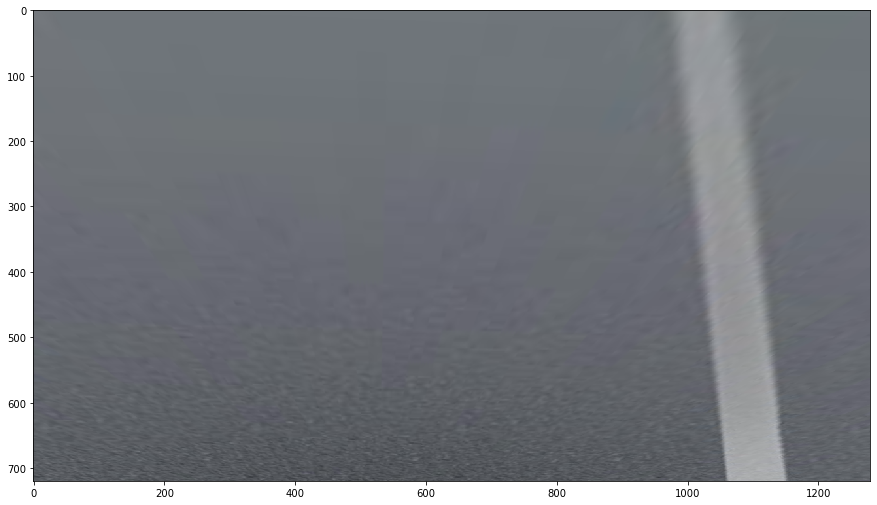

In [35]:
out_img = dataset[0][0]
out_img = cv2.imread(out_img)
img = transform.forward(out_img)
plt.figure(figsize=(15,10))
plt.imshow(img)
#plt.imshow(out_img)